In [80]:
import time
import numpy as np
import numpy.linalg as LA
import random
from collections import deque
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
def Kaczmarz(A,f,x_0,N_max,eps):
    x = np.copy(x_0)
    m = A.shape[0]
    res = np.array([np.linalg.norm(A @ x - f)/np.linalg.norm(f)])
    norms = np.zeros(m)
    #calculate row norms in advance
    for i in range(m):
        norms[i] = np.linalg.norm(A[i,:])**2
    #Kaczmarz method itself
    startTime = time.time()
    for i in range(N_max):
        k = i % m
        x = x + ((f[k] - np.dot(A[k,:],x))/norms[k])*A[k,:]
        #update residual
        new_res = np.linalg.norm(A @ x - f)/np.linalg.norm(f)
        res = np.append(res,[new_res])
        if new_res < eps:
            break
    endTime = time.time()
    return x,res,endTime-startTime

In [82]:
def SimpleRandomKaczmarz(A,f,x_0,N_max,eps):
    x = np.copy(x_0)
    m = A.shape[0]
    res = np.array([np.linalg.norm(A @ x - f)/np.linalg.norm(f)])
    norms = np.zeros(m)
    cum_norms = np.zeros(m)
    #calculate row norms in advance
    for i in range(m):
        norms[i] = np.linalg.norm(A[i,:])**2   
    np.random.seed(666)
    #just uniform distribution on the set of equations
    startTime = time.time()
    for i in range(N_max):
        k = np.random.randint(m)
        x = x + ((f[k] - np.dot(A[k,:],x))/norms[k])*A[k,:]
        #update residual
        new_res = np.linalg.norm(A @ x - f)/np.linalg.norm(f)
        res = np.append(res,[new_res])
        if new_res < eps:
            break
    endTime = time.time()
    return x,res,endTime-startTime

In [83]:
def RandomKaczmarz(A,f,x_0,N_max,eps):
    x = np.copy(x_0)
    m = A.shape[0]
    res = np.array([np.linalg.norm(A @ x - f)/np.linalg.norm(f)])
    norms = np.zeros(m)
    cum_norms = np.zeros(m)
    #calculate row norms in advance
    for i in range(m):
        norms[i] = np.linalg.norm(A[i,:])**2   
    cum_norms = np.cumsum(norms)
    cum_norms /= cum_norms[len(cum_norms)-1]
    np.random.seed(666)
    startTime = time.time()
    #Follow Strohmer, Vershinin
    for i in range(N_max):
        r = np.random.rand()
        k = np.searchsorted(cum_norms,r)
        x = x + ((f[k] - np.dot(A[k,:],x))/norms[k])*A[k,:]
        #update residual
        new_res = np.linalg.norm(A @ x - f)/np.linalg.norm(f)
        res = np.append(res,[new_res])
        if new_res < eps:
            break
    endTime = time.time()
    return x,res,endTime-startTime

Compare given $3$ methods on signal reconstruction.

In [78]:
#sample size
m = 500
r = 100
n = 2*r + 1
dots = np.random.rand(m)
sorted_dots = np.sort(dots)
true_coef = np.random.randn(n)
#we want Fourier coefficients to decrease as 1/n
for i in range(r):
    true_coef[r+i+1] = true_coef[r+i+1]/(i+1)
    true_coef[r-i-1] = true_coef[r-i-1]/(i+1)
#generate function values:
values = np.zeros(m,dtype=float)
A = np.zeros((m,n))
for i in range(m):
    for j in range(n):
        A[i,j] = np.cos(2*np.pi*(j-50)*dots[i])
        values[i] += true_coef[j]*np.cos(2*np.pi*(j-50)*dots[i])

System with matrix from normal distribution

In [95]:
#sample size
m = 150
n = 100
true_coef = np.random.randn(n)
#generate function values:
np.random.seed(666)
A = np.random.randn(m,n)
values = A @ true_coef

accelerating; iterNum: 10501, q_last: 0.898823
disparity of x:  3.09062004801e-06
accelerating; iterNum: 18301, q_last: 0.898776
disparity of x:  1.33511490103e-09
accelerating; iterNum: 23701, q_last: 0.898599
disparity of x:  3.17660811763e-12


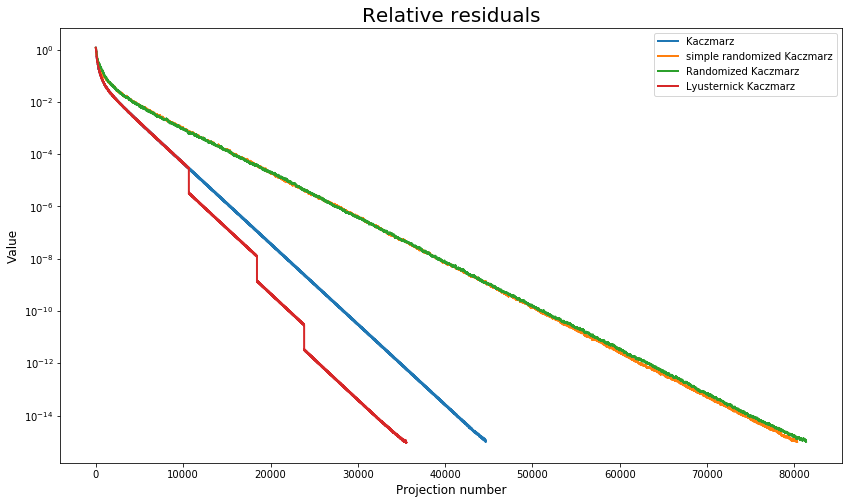

In [96]:
eps = 1e-15
N_max = 100000
np.random.seed(666)
x_0 = np.random.rand(n)
x_Car,res_Car,t_Car = Kaczmarz(A,values,x_0,N_max,eps)
x_simple_rand,res_simple_rand,t_simple_rand = SimpleRandomKaczmarz(A,values,x_0,N_max,eps)
x_rand,res_rand,t_rand = RandomKaczmarz(A,values,x_0,N_max,eps)
answer = calculate(A,values,eps,N_max,x_0)
plt.figure(figsize=(14,8))
plt.plot(res_Car, linestyle = '-', linewidth = 2.0, label='Kaczmarz')
plt.plot(res_simple_rand, linestyle = '-', linewidth = 2.0, label='simple randomized Kaczmarz')
plt.plot(res_rand, linestyle = '-', linewidth = 2.0, label='Randomized Kaczmarz')
plt.plot(answer['info']['res'], linestyle = '-', linewidth = 2.0, label='Lyusternick Kaczmarz')
plt.title('Relative residuals', fontsize = 20)
plt.ylabel('Value', fontsize = 12)
plt.xlabel('Projection number', fontsize = 12)
plt.yscale('log')
plt.legend()
plt.show()

In [60]:
def calculate(A,b,eps,maxIter,x0):
    '''Performs the main calculation procedure over the params.
    calculate(dict params, int testNo=None) -> dict answer
    '''
    # You can print a debug info onto the main screen
    
    answer = {}
    answer['info'] = {'calcTime': None, 'iterNum': None, 'res': None}
    startTime = time.time()
    iterNum = 1
    
    n = len(A)
    A = A.astype(float); b = b.astype(float)    # required for division
    # Norm each equation
    normCoef = np.transpose(np.sqrt(np.sum(A ** 2, 1)))
    A /= normCoef[:,None]
    b /= normCoef
    # Choosing random x0
    random.seed(None)   # inits with cur time or some dif-t random val
    x = np.copy(x_0)
    # using 2nd norm below (change to suit your needs)
    disparity = lambda x: LA.norm(b - np.dot(A, np.transpose(x)))/LA.norm(b)
    cosVectAngle = lambda a, b: np.inner(a, b) / LA.norm(a) / LA.norm(b)
    HPlane_Pnts = deque()
    lastVr = None
    q_last = None
    init_lastVr = False
    answer['info']['res'] = [disparity(x)]
    while iterNum < maxIter and disparity(x) >= eps:
        for i in range(n):
            t = A[i] @ x - b[i]
            x -= A[i] * t
            new_res = np.linalg.norm(A @ x - b)/np.linalg.norm(b)
            answer['info']['res'].append(new_res)
            if i == n - 1:
                HPlane_Pnts.append(np.copy(x))
        if len(HPlane_Pnts) > 3:
            HPlane_Pnts.popleft()
            #pprint(HPlane_Pnts)
            if not init_lastVr:
                prevVr = HPlane_Pnts[-2] - HPlane_Pnts[-3]
            else:
                prevVr = lastVr
            lastVr = HPlane_Pnts[-1] - HPlane_Pnts[-2]
            init_lastVr = True
            #print 'cos(angle): ', cosVectAngle(prevVr, lastVr)
            #if np.isclose(cosVectAngle(prevVr, lastVr), 1):
            
            q_prev = q_last
            q_last = LA.norm(lastVr) / \
                    LA.norm(prevVr)
            #print 'q_prev: {}, q_last: {} '.format(q_prev, q_last)
            if not (q_prev is None) and \
                q_last != 1 and \
                np.isclose(q_prev, q_last) and \
                np.isclose(cosVectAngle(prevVr, lastVr), 1):
                
                # Lyusternik acceleration
                print('accelerating; iterNum: %d, q_last: %f' % (iterNum, q_last))
                x = HPlane_Pnts[-1] + (HPlane_Pnts[-1] - HPlane_Pnts[-2]) / (1.0 - q_last)
                print('disparity of x: ', disparity(x))
                HPlane_Pnts.clear()
                
            #time.sleep(2)
        iterNum += n
    #add last residual
    new_res = np.linalg.norm(A @ x - b)/np.linalg.norm(b)
    answer['info']['res'].append(new_res)
    #end
    endTime = time.time()
    answer['x'] = x
    answer['info']['calcTime'] = endTime - startTime
    answer['info']['iterNum'] = iterNum
    answer['info']['disparity'] = disparity(x)
    if A.shape[0] == A.shape[1]:
        answer['info']['conditionNum'] = LA.norm(A) * LA.norm(LA.inv(A))
    else:
        answer['info']['conditionNum'] = 0
    return answer